In [2]:
import nltk
import string
import re
import numpy as np
import pandas as pd
import pickle
#import lda

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white")

from nltk.stem.porter import *
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import plotly.offline as py

py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
%matplotlib inline

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show, output_notebook
#from bokeh.transform import factor_cmap

import warnings

warnings.filterwarnings('ignore')
import logging

logging.getLogger("lda").setLevel(logging.WARNING)


In [3]:
train = pd.read_csv('train.tsv', sep='\t')
test = pd.read_csv('test.tsv', sep='\t')

In [4]:
print(train.shape)

(1482535, 8)


In [5]:
train.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

In [6]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [7]:
train.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

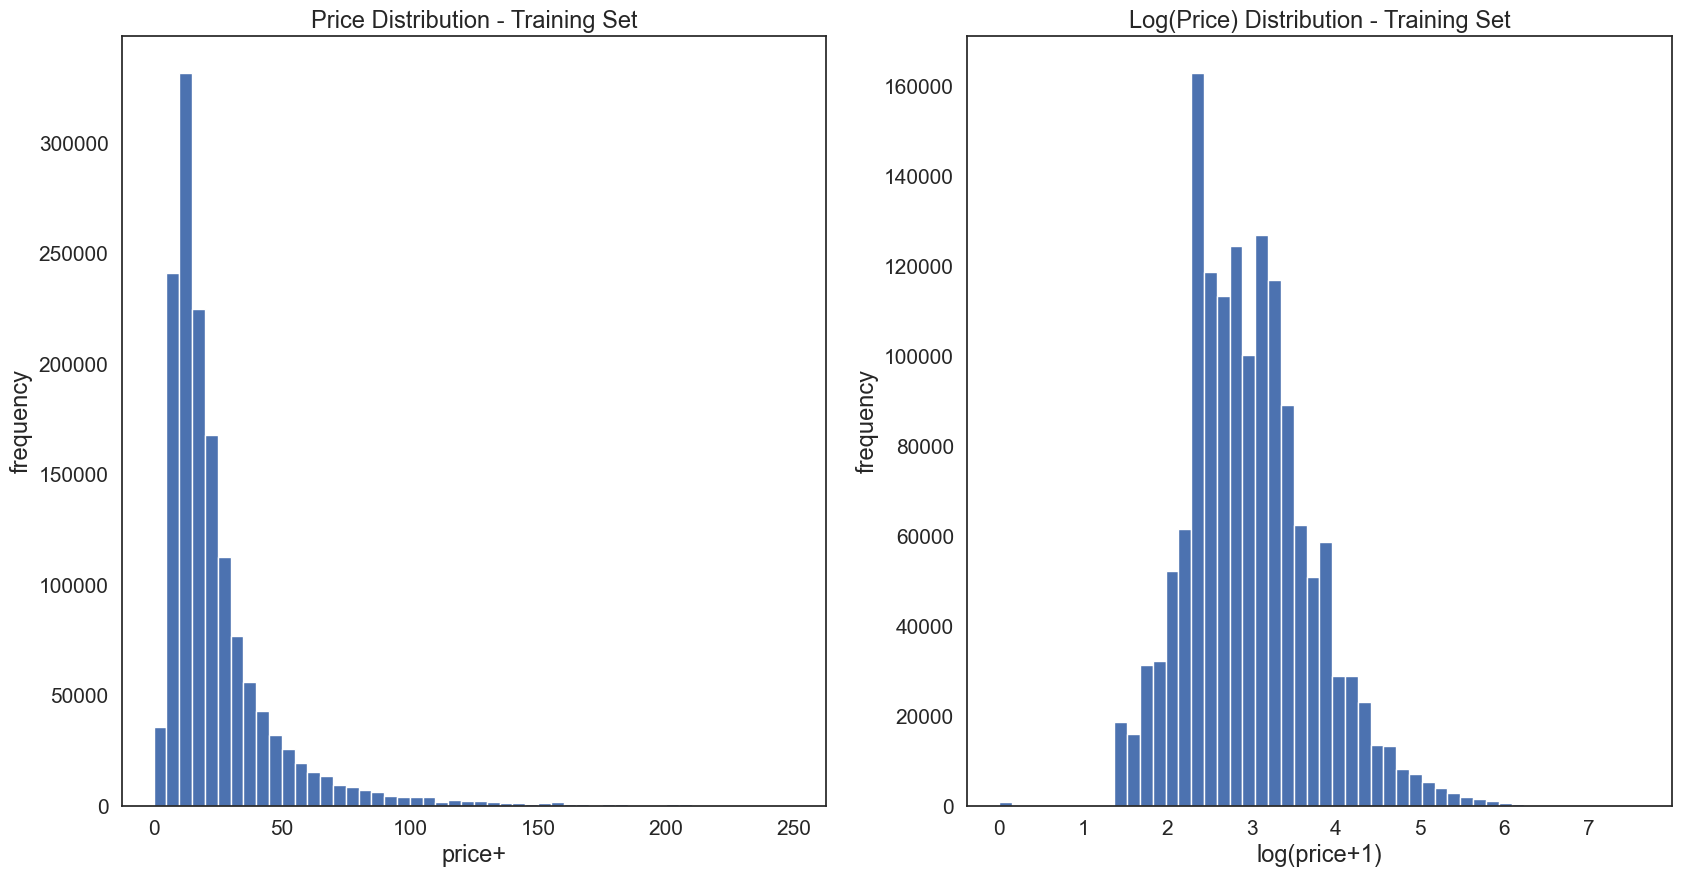

In [21]:
plt.subplot(1, 2, 1)
train['price'].plot.hist(bins=50, figsize=(20, 10), edgecolor='white', range=[0, 250])
plt.xlabel('price+', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Price Distribution - Training Set', fontsize=17)

plt.subplot(1, 2, 2)
np.log(train['price'] + 1).plot.hist(bins=50, figsize=(20, 10), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Log(Price) Distribution - Training Set', fontsize=17)
plt.show()

In [9]:
train.shipping.value_counts() / len(train)

shipping
0    0.552726
1    0.447274
Name: count, dtype: float64

In [10]:
prc_shipBySeller = train.loc[train.shipping == 1, 'price']
prc_shipByBuyer = train.loc[train.shipping == 0, 'price']

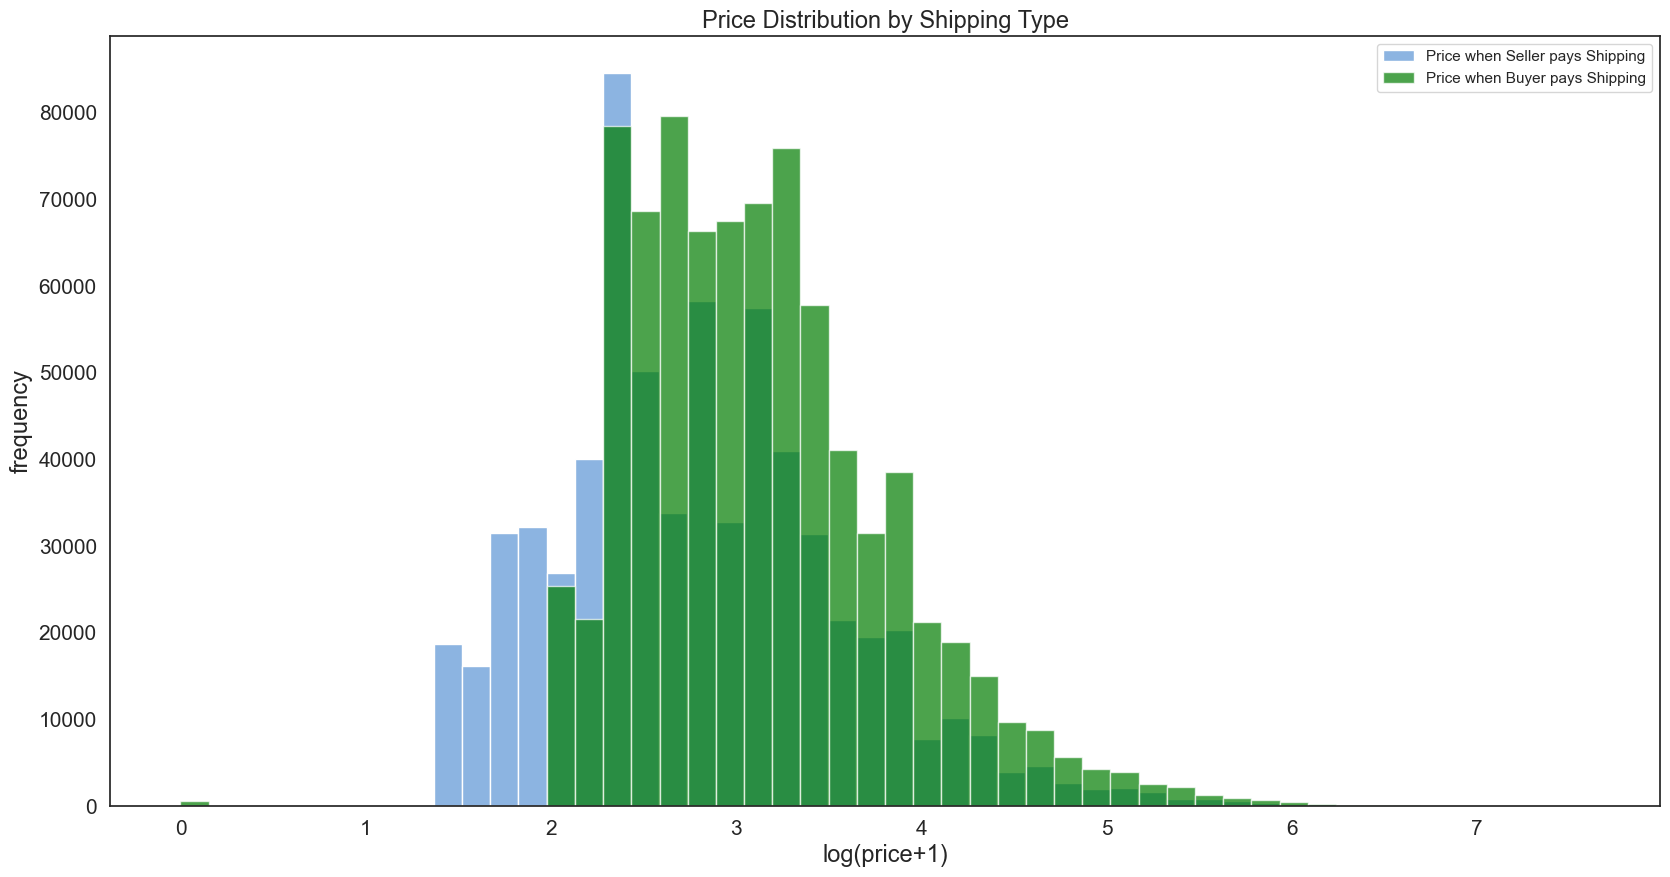

In [23]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.hist(np.log(prc_shipBySeller + 1), color='#8CB4E1', alpha=1.0, bins=50,
        label='Price when Seller pays Shipping')
ax.hist(np.log(prc_shipByBuyer + 1), color='#007D00', alpha=0.7, bins=50,
        label='Price when Buyer pays Shipping')
ax.set(title='Histogram Comparison', ylabel='% of Dataset in Bin')
plt.legend()
plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.title('Price Distribution by Shipping Type', fontsize=17)
plt.tick_params(labelsize=15)
plt.show()


In [12]:
def split_cat(text):
    try:
        return text.split("/")
    except:
        return ("No Label", "No Label", "No Label")


train['general_cat'], train['subcat_1'], train['subcat_2'] = zip(*train['category_name'].apply(lambda x: split_cat(x)))
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [13]:
print("There are %d unique first sub-categories." % train['subcat_1'].nunique())
print("There are %d unique second sub-categories." % train['subcat_2'].nunique())

There are 114 unique first sub-categories.
There are 871 unique second sub-categories.


In [14]:
x = train['general_cat'].value_counts().index.values.astype('str')

In [15]:
print(x)

['Women' 'Beauty' 'Kids' 'Electronics' 'Men' 'Home'
 'Vintage & Collectibles' 'Other' 'Handmade' 'Sports & Outdoors'
 'No Label']


In [16]:
y = train['general_cat'].value_counts().values
print(y)

[664385 207828 171689 122690  93680  67871  46530  45351  30842  25342
   6327]


In [17]:
pct = [("%.2f" % (v * 100)) + "%" for v in (y / len(train))]

In [18]:
trace1 = go.Bar(x=x, y=y, text=pct)
layout = dict(title='Number of Items by Main Category',
              yaxis=dict(title='Count'),
              xaxis=dict(title='Category'))
fig = dict(data=[trace1], layout=layout)
py.iplot(fig)